In [22]:
import numpy as np
from numba import njit, cfunc

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import json
import json
from numpy.linalg import norm
import seaborn as sns

from time import time
from numpy import cos, sin
from tqdm import tqdm

from scipy.integrate import odeint, quad, solve_ivp
from scipy.special import lpmn, lpmv, jv, jnyn_zeros, j0, j1
from scipy.stats import rv_continuous

%matplotlib inline

import warnings
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib

In [2]:
R_earth = 6400000.
R_moon = 1737100.
dist_moon = 380000000.
R_m = 16 * R_earth
b = 5 * R_earth
phi_ecl = np.pi / 36
cos_ecl = cos(phi_ecl)
sin_ecl = sin(phi_ecl)
g_10 = -29404.8 * 1e-9
g_11 = -1450.9 * 1e-9
h_11 = 4652.5 * 1e-9 
k_b = 1.38e-23
q = 1.6e-19 #Кл
m = 1.67e-27 #Кг
c = 3e8 #м/с
mu_0 = 4*np.pi * 1e-7 # Гн/м
m_x = 4*np.pi*R_earth**3 / mu_0 * g_11
m_y = 4*np.pi*R_earth**3 / mu_0 * h_11
m_z = 4*np.pi*R_earth**3 / mu_0 * g_10


maxiter = 10000
# B_imf_xyz = np.array([0, 0, -8e-9])
B_imf_xyz = np.array([2e-9, 0, 0])
C_i = 0.1
C_a = 0.2
lambd = 0.3
m_particles = 16*m
q_particles = q

In [3]:
def create_const_a(N=100):
    jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(0, 10)
    x_0 = jnp_roots
    jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(1, 10)
    x_1 = jnp_roots
    
    def f0(x):
            S = -b / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += -1 / b ** 2 * (n + 1) * (-b / R_m) ** (n + 1) * (x / R_m) ** n * lpmv(0, n, 0)
            return S


    def f1(x):
            S = x / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += 1 / b ** 2 * (n + 1) / n * (-b / R_m) ** (n + 1) * (x / R_m) ** n * (-lpmv(1, n, 0))
            return S

    def func(x, x_nn, v):
        if v == 0:
            return x * jv(0, x_nn * x / R_m) * f0(x)
        else:
            return x * jv(1, x_nn * x / R_m) * f1(x)


    a_0 = np.array([2 / (R_m ** 2 * jv(0, x_0[n]) ** 2) * quad(func, 0, R_m, args=(x_0[n], 0))[0] for n in
                    tqdm(range(N), desc="Подсчет a_0")])
    a_1 = np.array(
        [2 / (R_m ** 2 * jv(1, x_1[n]) ** 2 * (1 - (1 / x_1[n]) ** 2)) * quad(func, 0, R_m, args=(x_1[n], 1))[0] for
         n in tqdm(range(N), desc="Подсчет a_1")])
    return a_0, a_1, x_0, x_1

In [4]:
N=10

a_0, a_1, x_0, x_1 = create_const_a(N=N)

ns = np.arange(1, N+1)
R_m_arr = np.array([R_m]*N)
m_x_arr = np.array([m_x]*N)
m_y_arr = np.array([m_y]*N)
m_z_arr = np.array([m_z]*N)
mu_0_arr = np.array([mu_0]*N)

Подсчет a_1: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.03it/s]


In [5]:
@njit(cache=True)
def legs(theta):

    cos_theta = cos(theta)
    sin_theta = sin(theta)

    legs_0n = np.array([cos_theta, 1 / 2 * (3 * cos_theta ** 2 - 1),
                        1 / 2 * (5 * cos_theta ** 3 - 3 * cos_theta),
                        1 / 8 * (35 * cos_theta ** 4 - 30 * cos_theta ** 2 + 3),
                        1 / 8 * (63 * cos_theta ** 5 - 70 * cos_theta ** 3 + 15 * cos_theta),
                        1 / 16 * (231 * cos_theta ** 6 - 315 * cos_theta ** 4 + 105 * cos_theta ** 2 - 5),
                        1 / 16 * (
                                    429 * cos_theta ** 7 - 693 * cos_theta ** 5 + 315 * cos_theta ** 3 - 35 * cos_theta),
                        1 / 128 * (
                                    6435 * cos_theta ** 8 - 12012 * cos_theta ** 6 + 6930 * cos_theta ** 4 - 1260 * cos_theta ** 2 + 35),
                        1 / 128 * (
                                    12155 * cos_theta ** 9 - 25740 * cos_theta ** 7 + 18018 * cos_theta ** 5 - 4620 * cos_theta ** 3 + 315 * cos_theta),
                        1 / 256 * (
                                    46189 * cos_theta ** 10 - 109395 * cos_theta ** 8 + 90090 * cos_theta ** 6 - 30030 * cos_theta ** 4 + 3465 * cos_theta ** 2 - 63)]
                       )
    legs_1n = np.array([np.abs(sin_theta), 3 * cos_theta * np.abs(sin_theta),
                        3 / 2 * np.abs(sin_theta) * (5 * cos_theta ** 2 - 1),
                        5 / 2 * np.abs(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                        15 / 8 * np.abs(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                        21 / 8 * np.abs(sin_theta) * (33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                        7 / 16 * np.abs(sin_theta) * (
                                    429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                        9 / 16 * np.abs(sin_theta) * (
                                    715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                        45 / 128 * np.abs(sin_theta) * (
                                    2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                        55 / 128 * np.abs(sin_theta) * (
                                    4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                       )
    divlegs_0n = np.array([-sin_theta, -3 * sin_theta * cos_theta,
                           -3 / 2 * sin_theta * (5 * cos_theta ** 2 - 1),
                           -5 / 2 * sin_theta * cos_theta * (7 * cos_theta ** 2 - 3),
                           -15 / 8 * sin_theta * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                           -21 / 8 * sin_theta * cos_theta * (33 * cos_theta ** 4 - 30 * cos_theta ** 2 + 5),
                           -7 / 16 * sin_theta * (
                                       429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                           -9 / 16 * sin_theta * cos_theta * (
                                       715 * cos_theta ** 6 - 1001 * cos_theta ** 4 + 385 * cos_theta ** 2 - 35),
                           -45 / 128 * sin_theta * (
                                       2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                           -55 / 128 * sin_theta * cos_theta * (
                                       4199 * cos_theta ** 8 - 7956 * cos_theta ** 6 + 4914 * cos_theta ** 4 - 1092 * cos_theta ** 2 + 63)]
                          )
    divlegs_1n = np.array([cos_theta * np.sign(sin_theta), -3 * np.sign(sin_theta) * (1 - 2 * cos_theta ** 2),
                           -3 / 2 * np.sign(sin_theta) * cos_theta * (11 - 15 * cos_theta ** 2),
                           5 / 2 * np.sign(sin_theta) * (28 * cos_theta ** 4 - 27 * cos_theta ** 2 + 3),
                           15 / 8 * np.sign(sin_theta) * cos_theta * (
                                       105 * cos_theta ** 4 - 126 * cos_theta ** 2 + 29),
                           21 / 8 * np.sign(sin_theta) * (
                                       198 * cos_theta ** 6 - 285 * cos_theta ** 4 + 100 * cos_theta ** 2 - 5),
                           7 / 16 * np.sign(sin_theta) * cos_theta * (
                                       3003 * cos_theta ** 6 - 5049 * cos_theta ** 4 + 2385 * cos_theta ** 2 - 275),
                           9 / 16 * np.sign(sin_theta) * (
                                       5720 * cos_theta ** 8 - 11011 * cos_theta ** 6 + 6545 * cos_theta ** 4 - 1225 * cos_theta ** 2 + 35),
                           45 / 128 * np.sign(sin_theta) * cos_theta * (
                                       21879 * cos_theta ** 8 - 47476 * cos_theta ** 6 + 34034 * cos_theta ** 4 - 8932 * cos_theta ** 2 + 623),
                           55 / 128 * np.sign(sin_theta) * (
                                       41990 * cos_theta ** 10 - 101439 * cos_theta ** 8 + 85176 * cos_theta ** 6 - 28938 * cos_theta ** 4 + 3402 * cos_theta ** 2 - 63)]
                          )
    legs_1n_div_sin = np.array([np.sign(sin_theta), 3 * cos_theta * np.sign(sin_theta),
                                3 / 2 * np.sign(sin_theta) * (5 * cos_theta ** 2 - 1),
                                5 / 2 * np.sign(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                                15 / 8 * np.sign(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                                21 / 8 * np.sign(sin_theta) * (
                                            33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                                7 / 16 * np.sign(sin_theta) * (
                                            429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                                9 / 16 * np.sign(sin_theta) * (
                                            715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                                45 / 128 * np.sign(sin_theta) * (
                                            2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                                55 / 128 * np.sign(sin_theta) * (
                                            4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                               )

    return legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin

In [6]:
@njit
def meshgrid(x, y, z):
    xx = np.empty(shape=(x.size, y.size, z.size), dtype=x.dtype)
    yy = np.empty(shape=(x.size, y.size, z.size), dtype=y.dtype)
    zz = np.empty(shape=(x.size, y.size, z.size), dtype=z.dtype)
    for i in range(x.size):
        for j in range(y.size):
            for k in range(z.size):
                xx[i,j,k] = x[i]  # change to x[k] if indexing xy
                yy[i,j,k] = y[j]  # change to y[j] if indexing xy
                zz[i,j,k] = z[k]  # change to z[i] if indexing xy
    return xx, yy, zz


@njit
def make_start_points_for_magnetosphere(thetha_nums=10, phi_nums=10):
    theta = np.linspace(0, np.pi, thetha_nums)
    phi = np.linspace(0, 2 * np.pi, phi_nums)
    r = np.linspace(R_earth, R_earth, 1)
    

    th, ph, rr = meshgrid(theta, phi, r)

    th = np.expand_dims(th, axis=-1)
    ph = np.expand_dims(ph, axis=-1)
    rr = np.expand_dims(rr, axis=-1)

    start_points = np.concatenate((rr, th, ph), axis=-1)
    start_points = start_points.reshape(-1, 3)
    return start_points


@njit(cache=True)
def sphere_to_decart(point, B):
    r, theta, phi = point
    C = np.array([[sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)],
                  [cos(theta) * cos(phi), cos(theta) * sin(phi), -sin(theta)],
                  [-sin(phi), cos(phi), 0]])
    B_xyz = B @ C
    point_xyz = np.array([r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)])
    return B_xyz, point_xyz

@njit(cache=True)
def decart_to_sphere(x, y, z, eps=1e-8):
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(z / r)
    phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
    return np.array([r, theta, phi])

@njit(cache=True)
def spher_to_cyl(point):
    r, theta, phi = point

    rho = r * sin(theta)
    phi = phi
    z = r * cos(theta)

    return rho, phi, z

@njit(cache=True)
def cyl_to_dec(point, B):
    rho, phi, z = spher_to_cyl(point)
    C = np.array([[cos(phi), -sin(phi), 0.],
                  [sin(phi), cos(phi), 0.],
                  [0., 0., 1.]]
                 )
    B_xyz = C @ B
    point_xyz = np.array([rho * cos(phi), rho * sin(phi), z])
    return B_xyz, point_xyz


In [7]:
@njit
def conf_B_tail(point, lambd):
    rho, phi, z = spher_to_cyl(point)

    jv_1x_0 = np.array([j1(x_0[i] * rho / R_m) for i in range(N)])
    jv_1x_1 = np.array([j1(x_1[i] * rho / R_m) for i in range(N)])
    jv_0x_1 = np.array([j0(x_1[i] * rho / R_m) for i in range(N)])
    jv_0x_0 = np.array([j0(x_0[i] * rho / R_m) for i in range(N)])
    jv_2x_1 = np.array([jv(2., x_1[i] * rho / R_m) for i in range(N)])

    cos_phi = np.array([cos(phi)]*N)
    sin_phi = np.array([sin(phi)]*N)
    expx_1 = np.exp(-x_1[:N] * z / R_m)
    expx_0 = np.exp(-x_0[:N] * z / R_m)
    explambdx_1 = np.exp(-lambd * x_1[:N] * z / R_m)
    explambdx_0 = np.exp(-lambd * x_0[:N] * z / R_m)
    mu_0_arr = np.array([mu_0/(4*np.pi)]*N)

    res = [mu_0_arr / R_m_arr * (
                     (x_0 * a_0 * m_x_arr  * jv_1x_0 * (expx_0 + lambd*explambdx_0)
                      + 0.5 * x_1 * a_1 * (m_z_arr * cos_phi + m_y_arr * sin_phi)* (jv_2x_1 - jv_0x_1) * (expx_1 + lambd*explambdx_1)
                                                 )
                       ),
                     a_1 * mu_0_arr / rho * (
                         (m_z_arr * sin_phi - m_y_arr * cos_phi)* jv_1x_1 * (expx_1 + lambd * explambdx_1)
                       ),
                      mu_0_arr / R_m_arr * (
                          x_0  * a_0 * m_x_arr * jv_0x_0 * (expx_0 + explambdx_0)
                          + x_1 * a_1 * (m_z_arr * cos_phi + m_y_arr * sin_phi) * jv_1x_1 * (expx_1 + explambdx_1)
                                             )
                       ]

    res_sum = np.empty(len(res))
    for i in range(len(res)):
        res_sum[i] = np.sum(res[i])
    return res_sum / 2

@njit(cache=True)
def conf_B_sphere_cfa(point, B_imf_xyz):
    r, theta, phi = point

    legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = legs(theta)
    B_cfa_r = - (R_m / r) ** 3 * (
                B_imf_xyz[2] * legs_0n[0] + B_imf_xyz[0] * cos(phi) * legs_1n[0] + B_imf_xyz[1] * sin(phi) *
                legs_1n[0])
    B_cfa_theta = 0.5 * (R_m / r) ** 3 * (
                B_imf_xyz[2] * divlegs_0n[0] + B_imf_xyz[0] * cos(phi) * divlegs_1n[0] + B_imf_xyz[1] * sin(phi) *
                divlegs_1n[0])
    B_cfa_phi = 0.5 * (R_m / r) ** 3 * (
                -B_imf_xyz[0] * sin(phi) * legs_1n_div_sin[0] + B_imf_xyz[1] * cos(phi) * legs_1n_div_sin[0])
    return np.array([B_cfa_r, B_cfa_theta, B_cfa_phi])

@njit(cache=True)
def conf_B_cyl_cfa(point, B_imf_xyz):
    rho, phi, z = spher_to_cyl(point)
    R_mrho = (R_m / rho) ** 2
    B_cfa_rho = - R_mrho * (B_imf_xyz[0] * cos(phi) + B_imf_xyz[1] * sin(phi))
    B_cfa_phi = R_mrho * (-B_imf_xyz[0] * sin(phi) + B_imf_xyz[1] * cos(phi))
    B_cfa_z = 0
    return np.array([B_cfa_rho, B_cfa_phi, B_cfa_z])

@njit(cache=True)
def conf_B_dip_xyz_M(point):
    r_M, theta_M, phi_M = point
    x_M, y_M, z_M = r_M * sin(theta_M) * cos(phi_M), r_M * sin(theta_M) * sin(phi_M), r_M * cos(theta_M)

    r = np.sqrt((z_M + b) ** 2 + y_M ** 2 + x_M ** 2)

    R_r3 = (R_earth / r) ** 3
    R_r35 = (R_earth) ** 3 / (r ** 5)

    B_x = -R_r3 * g_10 + 3 * R_r35 * x_M * (
                -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
    B_y = -R_r3 * h_11 + 3 * R_r35 * y_M * (
                -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
    B_z = R_r3 * g_11 + 3 * R_r35 * (z_M + b) * (
                -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
    return np.array([B_x, B_y, B_z]), np.array([x_M, y_M, z_M])

@njit(cache=True)
def conf_B_cfi_N(point):
    r, theta, phi = point  # r_m, theta_m, phi_m

    legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = legs(theta)
    cos_phi = cos(phi)
    sin_phi = sin(phi)
    mu_0_with_b = mu_0 / (4 * np.pi * b ** 3)

    res = [mu_0_with_b * (ns + 1) * (-b / R_m) ** (ns + 2) * (r / R_m) ** (ns - 1) * (
                      -ns * m_x * legs_0n[:N] + (m_z * cos_phi + m_y * sin_phi) * legs_1n[:N]
              ),
              mu_0_with_b * (ns + 1) / ns * (-b / R_m) ** (ns + 2) * (r / R_m) ** (ns - 1) * (
                      -ns * m_x * divlegs_0n[:N] + (m_z * cos_phi + m_y * sin_phi) * divlegs_1n[:N]
              ),
              mu_0_with_b * (ns + 1) / ns * (-b / R_m) ** (ns + 2) * (r / R_m) ** (ns - 1) * (
                      (-m_z * sin_phi + m_y * cos_phi) * legs_1n_div_sin[:N])]
    
    res_sum = np.empty(len(res))
    for i in range(len(res)):
        res_sum[i] = np.sum(res[i])
    return res_sum

@njit
def conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz):
    x, y, z = point_xyz
    point = decart_to_sphere(x, y, z)  # x_m, y_m, z_m -> r_m, theta_m, phi_m

    # проверка в цилиндре мы или в полусфере
    if point_xyz[-1] < 0 and point[0] < R_m:

        B_dip_xyz, point_dip_xyz = conf_B_dip_xyz_M(point)

        B_cfi = conf_B_cfi_N(point)
        B_cfi_xyz, point_cfi_xyz = sphere_to_decart(point, B_cfi)

        B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz + C_a * B_imf_xyz
    elif point_xyz[-1] > 0 and point[0] * sin(point[1]) < R_m:

        B_tail = conf_B_tail(point, lambd)
        B_tail_xyz, point_tail_xyz = cyl_to_dec(point, B_tail)

        B_xyz = B_tail_xyz + C_a * B_imf_xyz
    elif point_xyz[-1] < 0 and point[0] >= R_m:
        B_cfa = conf_B_sphere_cfa(point, B_imf_xyz)
        B_cfa_xyz, point_cfa_xyz = sphere_to_decart(point, B_cfa)

        B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_xyz
    else:
        B_cfa_cyl = conf_B_cyl_cfa(point, B_imf_xyz)
        B_cfa_cyl_xyz, point_cfa_cyl_xyz = cyl_to_dec(point, B_cfa_cyl)

        B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_cyl_xyz

    return B_xyz

In [8]:
def make_Earth(data=None):
    def ms(x, y, z, radius, resolution=20):
        """Return the coordinates for plotting a sphere centered at (x,y,z)"""
        u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
        X = radius * np.cos(u) * np.sin(v) + x
        Y = radius * np.sin(u) * np.sin(v) + y
        Z = radius * np.cos(v) + z
        return (X, Y, Z)

    data = [] if data is None else data
    (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
    data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
    return data


def make_Moon(data=None):
    def ms(x, y, z, radius, resolution=20):
        """Return the coordinates for plotting a sphere centered at (x,y,z)"""
        u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
        X = radius * np.cos(u) * np.sin(v) + x
        Y = radius * np.sin(u) * np.sin(v) + y
        Z = radius * np.cos(v) + z
        return (X, Y, Z)

    data = [] if data is None else data
    (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b + dist_moon, 0, 0, R_moon)
    data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
    return data

def make_torus(data=None):
    def supertorus(R_out, R_in, resolution=20):
        #  initial range for values used in parametric equation
        u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
        x = (R_out + R_in*np.sin(v)) * np.cos(u)
        y = (R_out + R_in*np.sin(v)) * np.sin(u)
        z = R_in*np.cos(v)

        x = x*cos_ecl - z*sin_ecl - b
        y = y
        z = z*cos_ecl + x*sin_ecl

        return (x, y, z)

    data = [] if data is None else data
    (x_pns_surface, y_pns_surface, z_pns_suraface) = supertorus(dist_moon, R_moon)
    data.append(go.Surface(x=x_pns_surface,
                           y=y_pns_surface,
                           z=z_pns_suraface,
                           opacity=0.5))
    return data

def plot_image(data):
    fig = go.Figure(data=data)
    fig.update_layout(coloraxis_showscale=False)
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,
        scene=dict(
                 aspectmode='data'
         ))
    fig.for_each_annotation(lambda a: a.update(text=""))
    fig.show()


In [9]:
def make_magnetosphere(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10, data=None):
    data = [] if data is None else data
    for point in tqdm(make_start_points_for_magnetosphere(thetha_nums, phi_nums)):
        r = point[0]
        step = -1 if point[1] < np.pi / 2 else 1
        X = []
        Y = []
        Z = []
        i = 0

        r, theta, phi = point

        x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
        x_M, y_M, z_M = z, y, -(x + b)
        point_xyz = np.array([x_M, y_M, z_M])

        while R_earth <= r <= 5 * R_m and i < maxiter:

            X += [point_xyz[0]]
            Y += [point_xyz[1]]
            Z += [point_xyz[2]]

            B_xyz = conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz)

            # Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за
            # этого
            if (R_m - b) * 1 / 8 <= r <= (R_m - b) * 15 / 8:
                point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e5
            else:
                point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e6

            x, y, z = point_xyz

            r = np.sqrt(x ** 2 + y ** 2 + (z + b) ** 2)
            i += 1

        X += [point_xyz[0]]
        Y += [point_xyz[1]]
        Z += [point_xyz[2]]

        X = np.array(X)
        Y = np.array(Y)
        Z = np.array(Z)

        data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                 marker=dict(
                                     size=0.1,
                                     color='blue',  # set color to an array/list of desired values
                                     colorscale=None,  # choose a colorscale
                                     opacity=0.8
                                 ),
                                 showlegend=False
                                 )
                    )
    return data

@njit
def find_cusp(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10):
    R = []
    Thetha = []
    Phi = []
    for start_point in make_start_points_for_magnetosphere(thetha_nums, phi_nums):
        r = start_point[0]
        step = -1 if start_point[1] < np.pi / 2 else 1
        i = 0

        r, theta, phi = start_point

        x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
        x_M, y_M, z_M = z, y, -(x + b)
        point_xyz = np.array([x_M, y_M, z_M])

        while R_earth <= r <= 4 * R_m and i < maxiter:

            B_xyz = conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz)

            # Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за
            # этого
            if (R_m - b) * 1 / 8 <= r <= (R_m - b) * 15 / 8:
                point_xyz = point_xyz + step * B_xyz / norm(B_xyz) * 1e5
            else:
                point_xyz = point_xyz + step * B_xyz / norm(B_xyz) * 1e6

            x, y, z = point_xyz

            r = np.sqrt(x ** 2 + y ** 2 + (z + b) ** 2)
            i += 1

        if r >= R_earth:
            R.append(start_point[0])
            Thetha.append(start_point[1])
            Phi.append(start_point[2])

    return np.array(R), np.array(Thetha), np.array(Phi)

@njit(cache=True)
def points_from_cusp(thetha):
    thetha_up = thetha[thetha < np.pi / 2]
    thetha_down = thetha[thetha > np.pi / 2]

    th_up_n, th_down_n = max(thetha_up), min(thetha_up)
    th_up_s, th_down_s = max(thetha_down), min(thetha_down)

    return th_up_n, th_down_n, th_up_s, th_down_s

@njit(cache=True)
def if_in_tor(point_xyz):
    C = np.array([[cos_ecl, 0., -sin_ecl],
                  [0., 1., 0.],
                  [sin_ecl, 0., cos_ecl]])
    new_point = C @ point_xyz
    if new_point[1] == 0 and new_point[2] == 0:
        new_point = np.array([new_point[0], 0., 0.])
    else:
        new_point -= dist_moon / (np.sqrt(new_point[1]**2 + new_point[2]**2)) * np.array([0, new_point[1], new_point[2]])
    return norm(new_point) < R_moon


In [10]:
@njit
def pend(y, t, q, m, C_i, C_a, lambd, v_start):
        y1, y2, y3, y4, y5, y6 = y
        point = np.array([y1, y3, y5])
        r = y1 ** 2 + y3 ** 2 + (y5 + b) ** 2
        if (r < 25*R_earth**2
            or r >= (1.1*dist_moon)**2
            or if_in_tor(np.array([y1, y3, y5 + b]))
           ):
            return [0., 0., 0., 0., 0., 0.]
        B_xyz = conf_B(point, C_i, C_a, lambd, B_imf_xyz)
        v_xyz = np.array([y2, y4, y6])
        step = -1 if y1 < 0 else 1
        acc_dir = step*B_xyz / norm(B_xyz)
        f = [y2,
             q / m * (y4 * B_xyz[2] - y6 * B_xyz[1]) + 60*acc_dir[0] / (r / R_earth),
             y4,
             q / m * (y6 * B_xyz[0] - y2 * B_xyz[2]) + 60*acc_dir[1] / (r / R_earth),
             y6,
             q / m * (y2 * B_xyz[1] - y4 * B_xyz[0]) + 60*acc_dir[2] / (r / R_earth)]
        return f

In [11]:
def count_particles(C_i, C_a, lambd, B_imf_xyz, m_particles, q_particles,
                    download_part_name,
                    plotdata_flag=False, plotdata=None, download=False,
                    name_to_save="probabilities.txt", download_name="probabilities.txt"
                    ):


    plotdata = [] if plotdata is None else plotdata

    if download:
        try:
            with open(download_name, 'r') as f:
                data = json.load(f)
        except IOError:
            data = {'n': 1,
                    'drop': 0,
                    'last_particles': []}
    else:
        data = {'n': 1,
                'drop': 0,
                'last_particles': []}
    start_particles = np.load(download_part_name)
    pbar = tqdm(total=1000000, position=0, leave=True)
    pbar.update(data['n'])
    while data['n'] < 1000000:
        try:
            x_M, v_xM, y_M, v_yM, z_M, v_zM = start_particles[data['n']]

            # x, v_x, y, v_y, z, v_z
            y0 = [x_M, -v_xM,
                  y_M, -v_yM,
                  z_M, -v_zM]
            v = np.sqrt(v_xM**2 + v_yM**2 + v_zM**2)
            dt = 0.01 * 346064 / v
            t = np.linspace(0, 5000, int(5000 / dt))

            sol = odeint(pend, y0, t, args=(q_particles, m_particles, C_i, C_a, lambd, v*1e-3))

            X = sol[:, 0]
            Y = sol[:, 2]
            Z = sol[:, 4]

            point = np.array([X[-1], Y[-1], Z[-1] + b])
            r = norm(point)
            if r < 5*R_earth:
                data['drop'] += 1
                data['last_particles'] += [list(sol[-1])]
                if plotdata_flag:
                    plotdata.append(go.Scatter3d(x=Z[::10], y=Y[::10], z=X[::10],
                                             marker=dict(
                                                 size=0.1,
                                                 color='orange',  # set color to an array/list of desired values
                                                 colorscale=None,  # choose a colorscale
                                                 opacity=0.8
                                             )
                                             )
                                )
            data['n'] += 1

            pbar.set_description(f'Запущено: {data["n"]}, ' 
                                 f'Упало: {data["drop"]}, '
                                 f'Процент упавших: {data["drop"] / data["n"] * 100:0.2f}%'
                                 )
            pbar.update(1)
        except KeyboardInterrupt:
            print("Сохранение и выход")
            with open(name_to_save, 'w') as f:
                json.dump(data, f)
            break
    pbar.close()
    return plotdata, data['drop']

In [18]:
data, count = count_particles(C_i, C_a, lambd, B_imf_xyz, m_particles, q_particles,
                              plotdata_flag=True, plotdata=None, download=False,
                              name_to_save='b_z_2ntl_0.3_lambda_c_a_0.2.json',
                              download_name="b_z_2ntl_0.3_lambda_c_a_0.2.json",
                              download_part_name="b_z_2ntl_0.3_lambda_c_a_0.2.npy")

Запущено: 5, Упало: 0, Процент упавших: 0.00%:   0%|                            | 5/1000000 [00:02<92:23:52,  3.01it/s]D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

Запущено: 303, Упало: 3, Процент упавших: 0.99%:   0%|                        | 303/1000000 [00:32<29:33:15,  9.40it/s]

Сохранение и выход


In [19]:
plotdata = [data[0]]

In [51]:
data = data[:5]

In [22]:
data = make_Earth(data)
data = make_torus(data)

In [12]:
plot_image(data)

In [12]:
with open("b_z_2ntl_0.3_lambda_c_a_0.2.json", 'r') as f:
    moon_data = json.load(f)

In [22]:
start_particles = np.load('b_z_2ntl_0.3_lambda_c_a_0.2.npy')

In [13]:
len(moon_data['last_particles'])

3845

In [16]:
data = []
for last_part in moon_data['last_particles'][:500]:
    X, Y, Z = last_part[0], last_part[2], last_part[4]
    data.append(go.Scatter3d(x=[Z], y=[Y], z=[X],
                                 marker=dict(
                                     size=5,
                                     color='blue',  # set color to an array/list of desired values
                                     colorscale=None,  # choose a colorscale
                                     opacity=0.8
                                 )
                                 )
                    )

In [17]:
data = make_Earth(data)
data = make_torus(data)

In [19]:
# plot_image(data)

In [14]:
phies = []
thethas = []
for last_part in moon_data['last_particles']:
    X, Y, Z = last_part[0], last_part[2], last_part[4]
    point_xyz = np.array([X, Y, Z])
    C = np.array([[cos_ecl, 0., -sin_ecl],
                  [0., 1., 0.],
                  [sin_ecl, 0., cos_ecl]])
    new_point = C @ point_xyz
    x, y, z = new_point
    phies += [np.arctan(y / z) + np.pi/2 if z > 0 else np.arctan(y / z) + 3*np.pi/2]
    thethas += [np.arccos(x / np.sqrt(z**2 + y**2 + x**2))]

In [15]:
v_phies = []
v_thethas = []
v = []
for last_part in moon_data['last_particles']:
    v_x, v_y, v_z = last_part[1], last_part[3], last_part[5]
    point_xyz = np.array([v_x, v_y, v_z])
    C = np.array([[cos_ecl, 0., -sin_ecl],
                  [0., 1., 0.],
                  [sin_ecl, 0., cos_ecl]])
    new_point = C @ point_xyz
    v_x, v_y, v_z = new_point
    v_phies += [np.arctan(v_y / v_z) + np.pi/2 if v_z > 0 else np.arctan(v_y / v_z) + 3*np.pi/2]
    v_thethas += [np.arccos(v_x / np.sqrt(v_z**2 + v_y**2 + v_x**2))]
    v += [np.sqrt(v_x**2 + v_y**2 + v_z**2)]

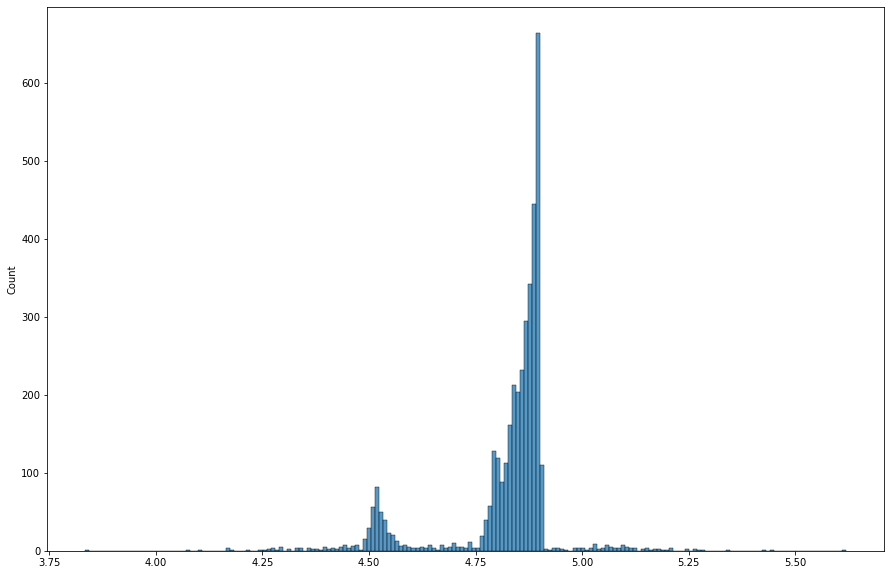

In [16]:
plt.figure(figsize=(15,10))
sns.histplot(phies);

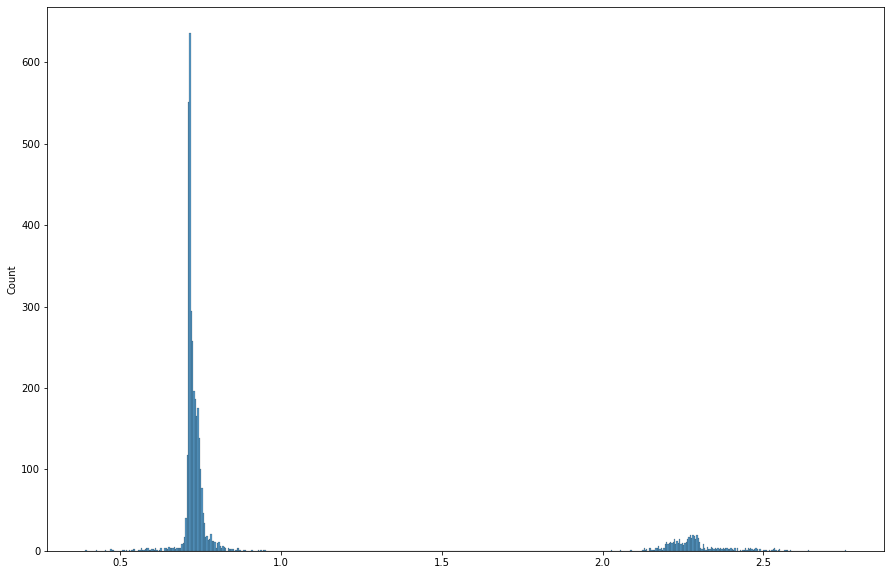

In [17]:
plt.figure(figsize=(15,10))
sns.histplot(thethas);

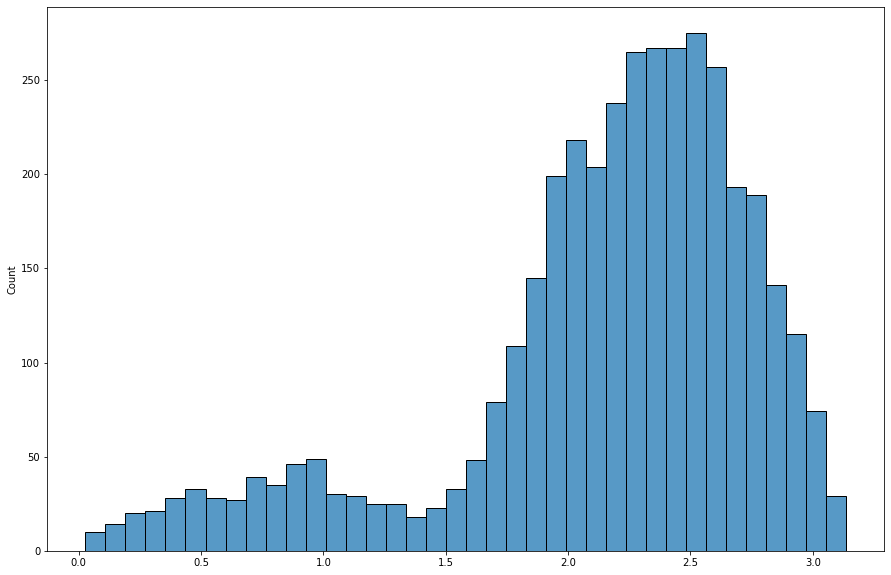

In [18]:
plt.figure(figsize=(15,10))
sns.histplot(v_thethas);

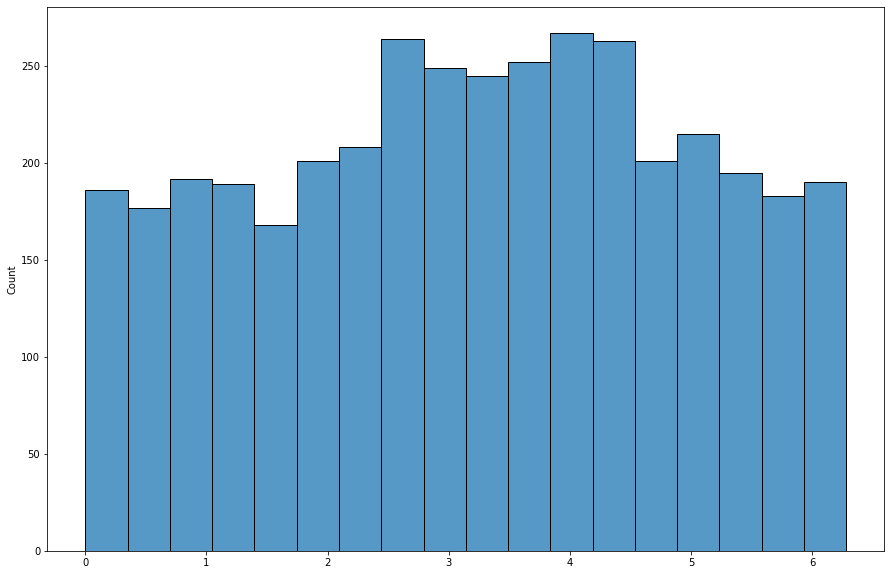

In [19]:
plt.figure(figsize=(15,10))
sns.histplot(v_phies);

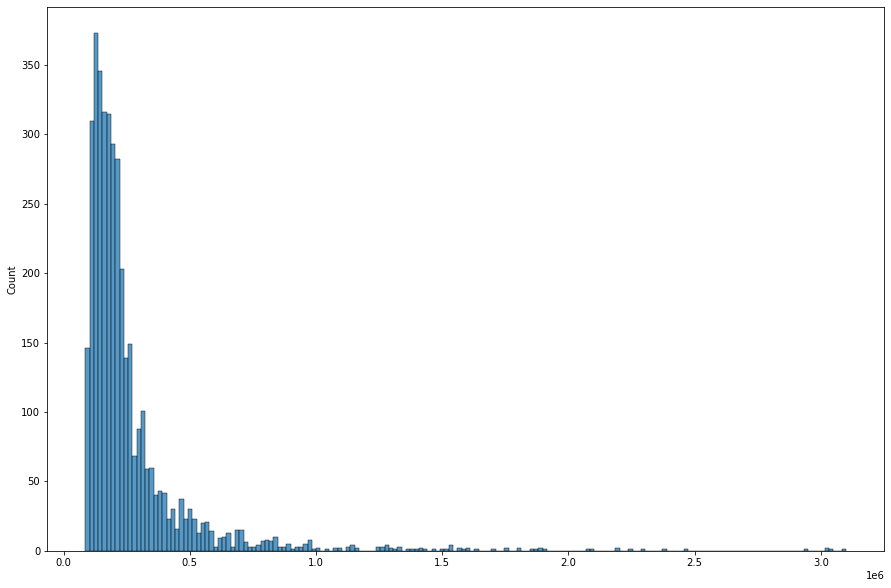

In [20]:
plt.figure(figsize=(15,10))
sns.histplot(v);

In [23]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

Text(0, 0.5, 'Частота')

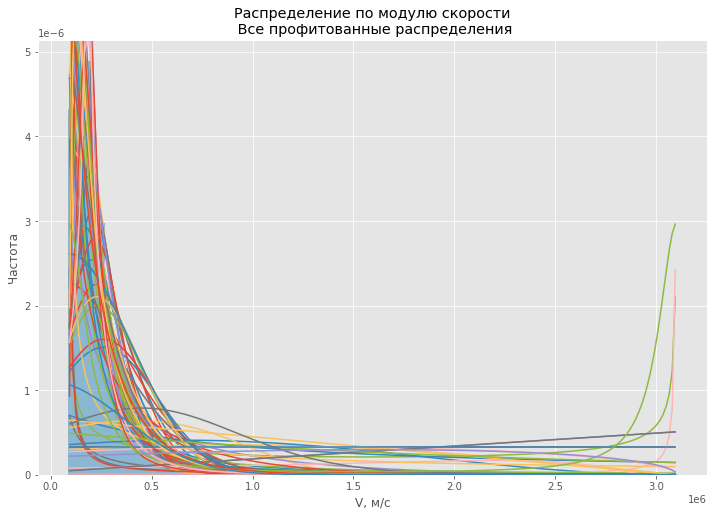

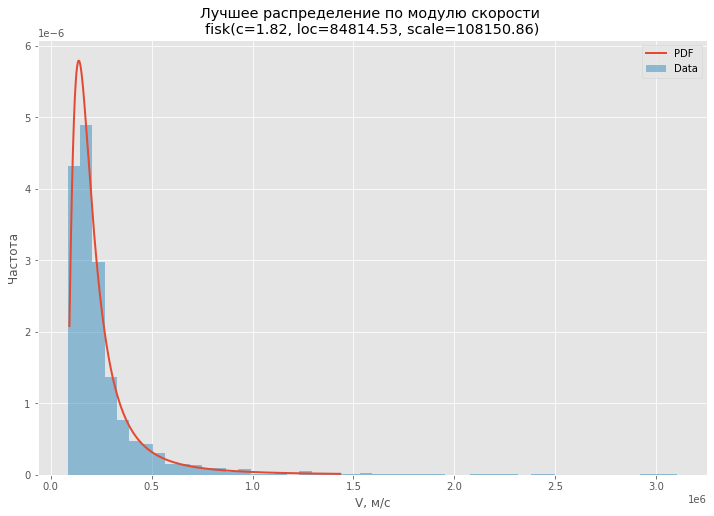

In [85]:

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(v)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Распределение по модулю скорости\n Все профитованные распределения')
ax.set_xlabel(u'V, м/с')
ax.set_ylabel('Частота')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Лучшее распределение по модулю скорости \n' + dist_str)
ax.set_xlabel(u'V, м/с')
ax.set_ylabel('Частота')

In [30]:
dist_str

'fisk(c=1.82, loc=84814.53, scale=108150.86)'

In [32]:
best_distibutions

[(<scipy.stats._continuous_distns.fisk_gen at 0x1a8a2d8c460>,
  (1.8206188401968593, 84814.52928769405, 108150.86031798043),
  3.968855128283536e-12),
 (<scipy.stats._continuous_distns.burr_gen at 0x1a8a2d7e8b0>,
  (2.395169518262951,
   18975.024236266094,
   -41.99259757870918,
   2740.9273071978114),
  4.446065169664705e-12),
 (<scipy.stats._continuous_distns.nct_gen at 0x1a8a2e1c4c0>,
  (2.5631723580677876,
   37.26832275695611,
   2.472721724281228,
   4630.899344616092),
  4.811466112346154e-12),
 (<scipy.stats._continuous_distns.invgamma_gen at 0x1a8a2ddf2b0>,
  (2.194591493626665, 57632.676777621375, 251151.15259686083),
  5.110842009063443e-12),
 (<scipy.stats._continuous_distns.geninvgauss_gen at 0x1a8a2dea460>,
  (-2.0133451269702634,
   0.42645536608823853,
   59541.03368088837,
   1075286.4679625914),
  5.254026283725037e-12),
 (<scipy.stats._continuous_distns.exponweib_gen at 0x1a8a2d92dc0>,
  (71.03825459904147,
   0.29020076462707856,
   74043.63178115097,
   601.132492